#### Imports

In [1]:
# Web scraping and working with web data
import requests
from bs4 import BeautifulSoup
import json

# Data manipulation and analysis
import pandas as pd

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Image handling and manipulation
from PIL import Image as PILImage
from io import BytesIO
from IPython.display import display, Image  # For displaying images inline

# Operating system utilities
import os


#### Settings and Constants

In [2]:
# set pandas options to show dataframe columns on single lines

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Wide enough for no wrapping
pd.set_option('display.max_colwidth', None)  # Avoid truncating long text

# Supress warnings
import warnings
warnings.filterwarnings("ignore")

# Define ANSI escape codes for red text
RED = "\033[91m"
GREEN = "\033[92m"
YELLOW = "\033[93m"
ORANGE = "\033[38;5;208m"
L_ORANGE = "\033[38;5;214m"
RESET = "\033[0m"

***
<span style="color: red; font-weight: bold; font-size: 30px;">1.</span> 
<span style=" font-size: 30px;">Webscraping</span> 

- Scrape the data of the first 50 pages of the website https://www.skinnytaste.com
(your scraper of choice)

In [3]:

#******************************************************************************************[scraper_settings]
"Function to set up the scraping parameters"
def scraper_settings():
    # INITIALIZE VARIABLES
    index_url = 'https://www.skinnytaste.com/recipe-index/'
    pages_to_scrape = 3  # Change this to control how many pages to scrape
    exclude_keywords = ['deals', 'free', 'easy', 'best', 'kitchen', 'ideas', 'memorial','fathers']  # Keywords to exclude
    return index_url, pages_to_scrape, exclude_keywords


#******************************************************************************************[extract_recipe_links]
"Function to extract recipe links from a website's paginated index"
def extract_recipe_links(index_url, pages=1, exclude_keywords=None, max_links=50):

    # PRINT FUNCTION EXECUTION AND INITIALIZE VARIABLES
    print(f"{RED}Extracting recipe links{RESET}")
    # exclusion keywords filter out the returned links with bad results, aka not recipes 
    if exclude_keywords is None:
        exclude_keywords = []
    # list to store the extracted recipe links
    recipe_links = []

    # LOOP THROUGH THE RECIPE <INDEX PAGES> FETCHING THE LINKS TO CONTENT
    for page in range(1, pages + 1):
        # construct the URL for the specific page of the index
        paginated_url = f"{index_url}?_paged={page}" ; print(f"paginated_url: {paginated_url}")
        # make a request to fetch the page content
        response = requests.get(paginated_url)
        # if the request fails, skip to the next page
        if response.status_code != 200:
            print(f"Failed to retrieve the index page: {response.status_code}")
            continue
        
        # PARSE THE HTML CONTENT OF THE <INDEX PAGES> USING BEAUTIFULSOUP   
        soup = BeautifulSoup(response.text, 'html.parser')
        # select all article elements containing recipes
        articles = soup.select('article.post')
        # print number of article elements containing recipes found on page
        print(f"Number of articles found on page {GREEN}{page}{RESET}: {L_ORANGE}{len(articles)}{RESET}") 

        # LOOP THROUGH EACH <ARTICLE> TO EXTRACT THE RECIPE LINK
        for article in articles:
            # find the link inside the article's title
            link = article.select_one('h2.entry-title a') 
            # check if the link is valid
            if link and link.get('href'): 
                href = link.get('href')
                # check if the link contains any of the exclude keywords
                if not any(keyword in href for keyword in exclude_keywords):
                    # else add the valid recipe link to the list
                    recipe_links.append(href) 
                    # if the number of extracted links reaches the limit, break the loop
                    if len(recipe_links) >= max_links:
                        break
         # Stop going through pages if the maximum number of links has been reached
        if len(recipe_links) >= max_links:
            break

    # Print the total number of recipe links extracted
    print(f"Total number of recipe links extracted: {L_ORANGE}{len(recipe_links)}{RESET}")  # Debugging line
    return recipe_links


#******************************************************************************************[scrape recipe]
"Function to scrape individual recipe data from a given URL"
def scrape_recipe(url):

    # GET THE INDIVIDUAL RECIPE PAGE CONTENT
    # request the content of the recipe page
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to retrieve the page: {response.status_code}")
        return None
    else: 
        return response

    
#############################################################
# set the scraper initial settings
index_url, pages_to_scrape, exclude_keywords = scraper_settings()

# retrieve the links for individual recipes
recipe_links = extract_recipe_links(index_url, pages_to_scrape, exclude_keywords, max_links=51)

# list to store scraped recipes
all_recipes = []
# iterate over the extracted recipe links and scrape each recipe
print(f"\n{RED}Extracting each individual recipe page{RESET}")
for recipe_link in recipe_links:
    print(f"Scraping recipe: {recipe_link}")
    recipe = scrape_recipe(recipe_link)
    if recipe:
        all_recipes.append(recipe)

Extracting recipe links
paginated_url: https://www.skinnytaste.com/recipe-index/?_paged=1
Number of articles found on page 1: 20
paginated_url: https://www.skinnytaste.com/recipe-index/?_paged=2
Number of articles found on page 2: 20
paginated_url: https://www.skinnytaste.com/recipe-index/?_paged=3
Number of articles found on page 3: 20
Total number of recipe links extracted: 50

Extracting each individual recipe page
Scraping recipe: https://www.skinnytaste.com/crustless-pumpkin-pie/
Scraping recipe: https://www.skinnytaste.com/red-curry-salmon/
Scraping recipe: https://www.skinnytaste.com/apple-butter-recipe/
Scraping recipe: https://www.skinnytaste.com/roasted-delicata-squash/
Scraping recipe: https://www.skinnytaste.com/applesauce-nut-bread/
Scraping recipe: https://www.skinnytaste.com/autumn-salad-with-pears-and-gorgonzola/
Scraping recipe: https://www.skinnytaste.com/sesame-chicken/
Scraping recipe: https://www.skinnytaste.com/bacon-in-the-oven/
Scraping recipe: https://www.skinn

***
<span style="color: red; font-weight: bold; font-size: 30px;">2.</span> 
<span style=" font-size: 30px;">Filter Interesting Data</span> 

- Name of the food
- Image of the food
- Calories
- Personal Points
- Summary
- The recipe Key (Could be found on the website)


In [13]:

#******************************************************************************************[filter content]
"Function to fetch relevant recipe page details from a given stored recipe page"
def filter_content(response, url):
    # parse the html content of the recipe page
    soup = BeautifulSoup(response.text, 'html.parser')

    # EXTRACT FROM JSON-LD
    # html page include json-ld section specifically to provide structured data for scrapers
    # get the json-ld data
    json_ld_script = soup.find('script', type='application/ld+json')
    if not json_ld_script:
        print("No JSON-LD data found on this page.")
        return None
    # parse the json-ld data, making it python object
    try:
        data = json.loads(json_ld_script.string)               #; print(f"parsed ld data: {data}") # debug
    except json.JSONDecodeError:
        print("Failed to parse JSON-LD data.")
        return None
    # extract recipe data from structure
    recipe_data = None
    if isinstance(data, dict) and '@graph' in data:
        # type element contains the relevant data to extract
        for item in data['@graph']:
            if item.get('@type') == 'Recipe':
                recipe_data = item                             #; print(f"recipe_data: {recipe_data}") # debug
                break
    if not recipe_data:
        print("No recipe data found in JSON-LD.")
        return None
    # extract the specific details from the element
    recipe_name = recipe_data.get('name', 'No name available') #; print(f"recipe_name: {recipe_name}") # debug
    ingredients = recipe_data.get('recipeIngredient', [])      #; print(f"ingredients: {ingredients}") # debug
    instructions = recipe_data.get('recipeInstructions', [])   #; print(f"instructions: {instructions}") # debug
    nutrition = recipe_data.get('nutrition', {})               #; print(f"nutrition: {nutrition}") # debug
    image_urls = recipe_data.get('image', [])                  #; print(f"image_urls: {image_urls}") # debug

    instruction_texts = []
    for step in instructions:
        if isinstance(step, dict) and 'text' in step:
            instruction_texts.append(step['text'])
        else:
            instruction_texts.append(step)

    # EXTRACT ADDITIONAL FIELDS, NOT IN JSON-LD, USING BEAUTIFULSOUP
    # summary
    summary = soup.select_one("div.entry-content.clear > p:nth-of-type(4)")
    summary_text = summary.get_text(strip=True) if summary else 'N/A'                          #; print(f"summary_text: {summary_text}") # debug
    # personal points
    personal_points = soup.select_one("span.recipe-meta-value.recipe-ww-pp.icon")
    personal_points_text = personal_points.get_text(strip=True) if personal_points else 'N/A'  #; print(f"personal_points: {personal_points}") # debug
    # recipe keys
    recipe_keys_section = soup.select('.post-icons li a')
    recipe_keys = [key.get_text(strip=True) for key in recipe_keys_section]                    #; print(f"recipe_keys: {recipe_keys}") # debug


    # Compile all recipe details into a dictionary
    recipe_details = {
        'Name': recipe_name,
        'Ingredients': ', '.join(ingredients),
        'Instructions': ' | '.join(instruction_texts),
        'Nutrition': nutrition,  # Stored as a dictionary
        'Image URL': image_urls[0] if image_urls else 'No image available',
        'Summary': summary_text,
        'Personal Points': personal_points_text,
        'Recipe Key': ', '.join(recipe_keys),
        'Recipe Link': url
    }

    return recipe_details


#******************************************************************************************[clean_and_prep_dataset]
"Function to prepare the data, further extract and create the dataset from the raw scraped recipe page details"
def prep_and_create_dataset(recipes):
    # Prepare a list to store cleaned data
    cleaned_data = []

    # ITERATE OVER EACH RECIPE PAGE RETURNED DETAILS CONTENT
    for index, recipe_data in enumerate(recipes):
        try:
            #print(f"Recipe {index} keys: {recipe_data.keys()}") # Debug: Print the keys in the recipe data

            # GET ALL OTHER FIELDS EXCEPT CALORIES DATA
            # create a dictionary `cleaned_row` to store/retrieve only the relevant fields with default values if missing
            cleaned_row = {
                'Name': recipe_data.get('Name', 'N/A'),
                'Image URL': recipe_data.get('Image URL', 'N/A'),
                'Calories': 'N/A',  # Default value
                'Personal Points': recipe_data.get('Personal Points', 'N/A'),
                'Summary': recipe_data.get('Summary', 'N/A'),
                'Recipe Key': recipe_data.get('Recipe Key', 'N/A')
            }

            # GET THE CALORIES DATA
            nutrition_data = recipe_data.get('Nutrition', {})
            # extract the 'calories' value from the `nutrition_data` dictionary
            cleaned_row['Calories'] = nutrition_data.get('calories', 'N/A')
            # append the cleaned row to the `cleaned_data` dict
            cleaned_data.append(cleaned_row)

        except json.JSONDecodeError:
            print(f"Error decoding JSON for recipe {index}")

    # CONVERT THE CLEANED DATA INTO A DATAFRAME
    cleaned_df = pd.DataFrame(cleaned_data)

    return cleaned_df


#############################################################
# list to store scraped recipes details
all_recipes_details = []

# extrtract the relevant parts of scraped recipe pages html content 
print(f"{RED}Extracting recipe details from scraped page{RESET}")
for i, recipe_response in enumerate(all_recipes):
    if recipe:
        recipe_details = filter_content(recipe_response, recipe_link)  # Pass the response, not the dict
        if recipe_details:  # Ensure that you only append valid recipe details
            print(f"Sections, page {L_ORANGE}{i}{RESET}: {recipe_details}")
            all_recipes_details.append(recipe_details)


# pass the extracted relevant parts to be cleaned, further refine the extraction and form a dataframe
cleaned_recipes_df = prep_and_create_dataset(all_recipes_details)

# display the cleaned DataFrame
print(f"\n{RED}The dataframe formed after relevant parts are cleaned and the extraction further refined{RESET}")
print(cleaned_recipes_df)


Extracting recipe details from scraped page
Sections, page 0: {'Name': 'Crustless Pumpkin Pie Recipe', 'Ingredients': '2 15-ounce cans pumpkin puree, 1 cup coconut milk (full-fat canned ), ¾ cup pure maple syrup (I use Wholesome Yum Keto Maple Syrup), 6 large  eggs, 1 tablespoon pumpkin pie spice, 1  lemon (Zest of), 2 teaspoons vanilla extract, 1 pinch sea salt, Dairy-free whipped cream for serving (optional)', 'Instructions': 'Preheat oven to 350°F. | In a medium bowl, whisk together pumpkin puree, coconut milk, maple syrup, eggs, pumpkin pie spice, lemon zest, vanilla, and salt until smooth and no lumps are visible. Equally pour into ten 4-ounce ramekins and place on a baking sheet. | Bake for 25 to 30 minutes. | Custards should jiggle slightly in center when removed from oven. Let cool to room temperature, then refrigerate for 1 hour. | Serve with whipped cream, if desired.', 'Nutrition': {'@type': 'NutritionInformation', 'servingSize': '1 ramekin', 'calories': '124.5 kcal', 'carbo

***
<span style="color: red; font-weight: bold; font-size: 30px;">3.</span> 
<span style=" font-size: 30px;">EDA and Visualisation</span> 

Use the appropriate visualisation method to provide information on
- Calories distribution
- Recipe key distribution
- Points distribution

Plot Calories distribution

 Value counts: 
 Calories
513.0    1
453.0    1
433.0    1
418.0    1
394.0    1
384.0    1
364.0    1
357.0    1
356.0    1
349.0    1
328.0    1
314.0    1
308.0    1
296.0    1
295.0    1
290.0    1
288.5    1
280.0    1
276.0    1
272.0    1
267.0    1
266.0    1
223.0    1
215.0    1
202.0    1
201.0    1
199.0    1
180.0    1
177.0    1
175.0    1
169.0    1
145.0    1
124.5    1
124.0    2
123.0    1
115.0    2
111.0    1
106.0    2
97.0     1
85.0     1
60.3     1
60.0     2
38.0     1
34.0     1
13.0     1
Name: count, dtype: int64


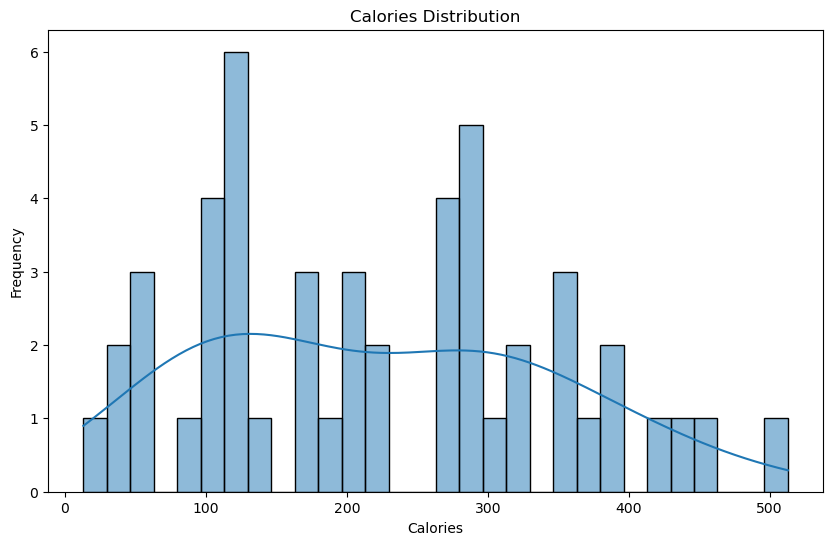


  Plot Personal Points distribution

 Value counts: 
 Personal Points
2     8
5     8
4     7
6     6
3     5
1     3
7     3
9     2
10    2
0     2
12    1
8     1
13    1
Name: count, dtype: int64


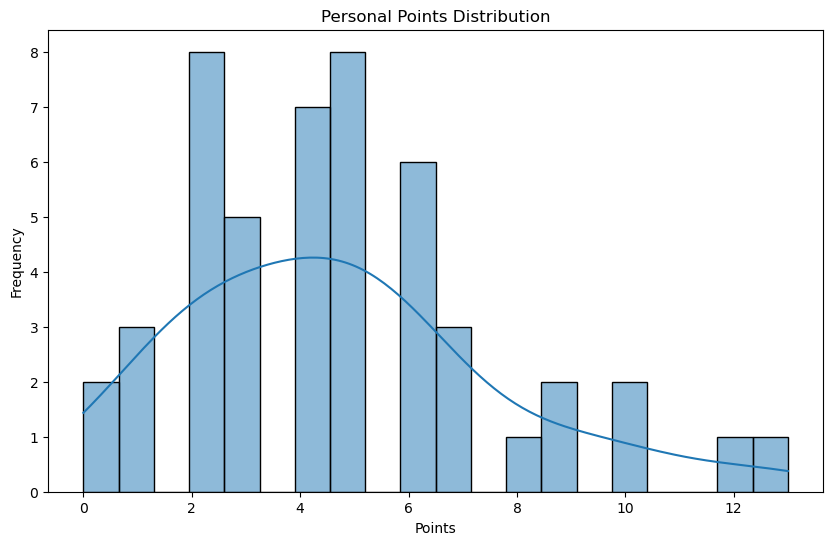


 Plot Recipe Keys distribution 



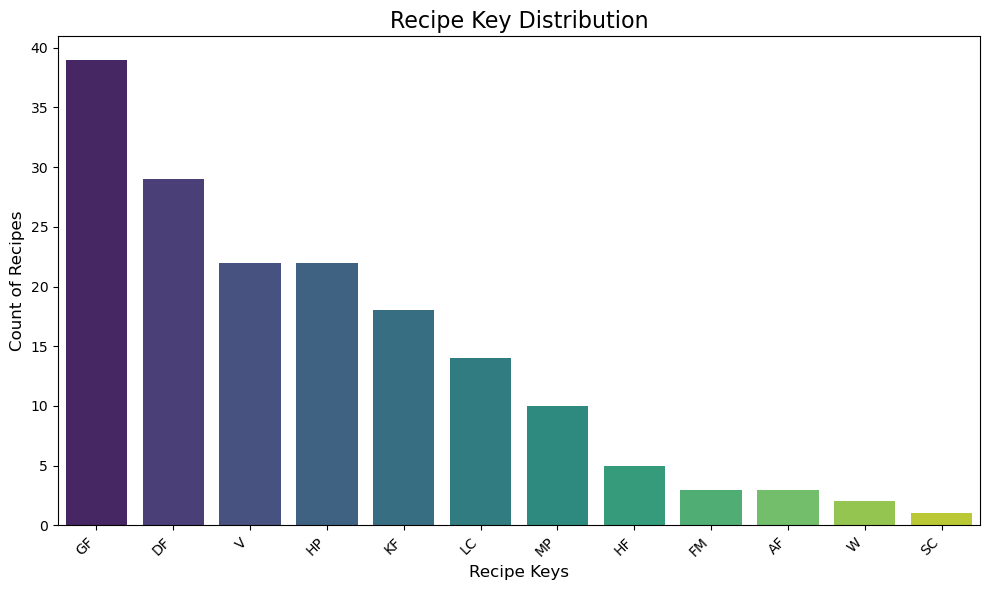


 Plot Distribution between calories & Personal Points 
 


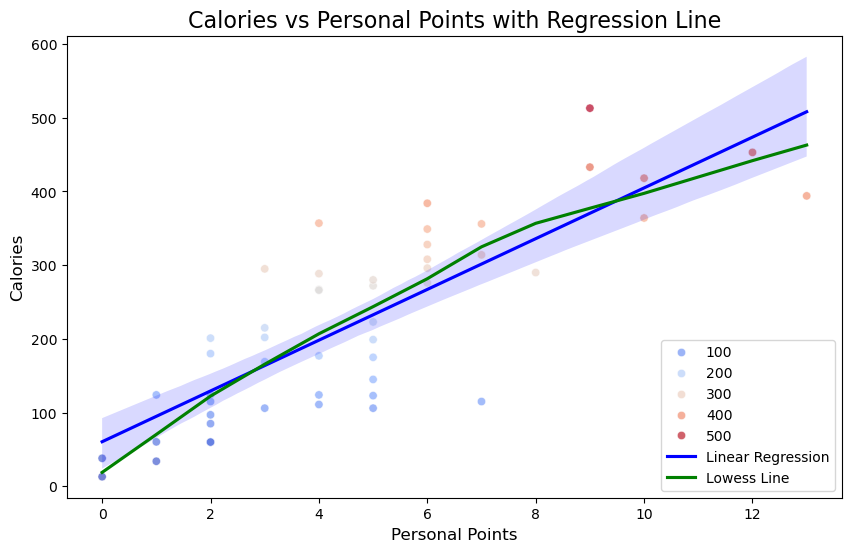

Correlation between Calories and Personal Points: 0.81 


  Plot Average Personal Points by Recipe Key 
 


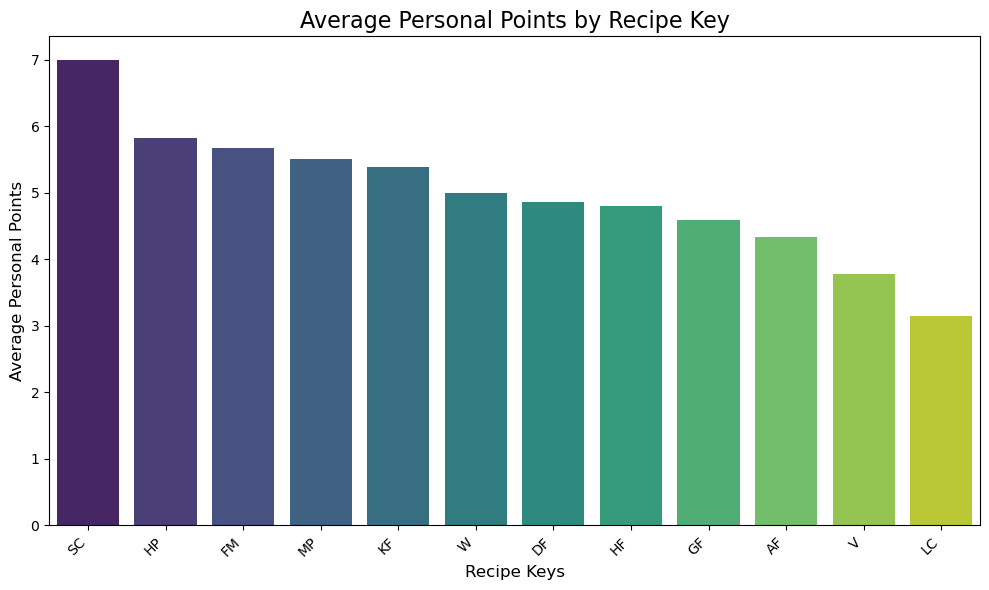

 Total personal points grouped by recipe key: 
 Recipe Key
GF    179
DF    141
HP    128
KF     97
V      83
MP     55
LC     44
HF     24
FM     17
AF     13
W      10
SC      7
Name: Personal Points, dtype: int64

 Count of recipe key grouped by recipe key: 
 Recipe Key
GF    39
DF    29
HP    22
V     22
KF    18
LC    14
MP    10
HF     5
AF     3
FM     3
W      2
SC     1
Name: Personal Points, dtype: int64


In [8]:

#******************************************************************************************[load_calories_and_pp]
"Loads, cleans and formats - Calories and Personal Points"
def load_calories_and_pp(df):
    # extract the first value from calories
    df_calories = df['Calories'].str.split().str[0]  
    # convert calories to numeric
    df_calories = pd.to_numeric(df_calories, errors='coerce') 
    # extract pp while converting to numeric
    df_pp = pd.to_numeric(df['Personal Points'], errors='coerce')

    # debug
    # print(df_calories.info())
    # print(df_calories.value_counts())
    # print(df_calories)
    # print(df_calories.dtypes)
    # print(df_pp.info())
    # print(df_pp.value_counts())
    # print(df_pp)
    # print(df_pp.dtypes)

    return df_calories, df_pp


#******************************************************************************************[load_recipe_keys]
"Loads, cleans and formats - Recipe Keys"
def load_recipe_keys(df):
    # make a copy of the dataframe to prevent altering the original
    df = df.copy()                                                                                    #; print(df.info()) # debug
    # split the recipe keys using known abbreviations as lookahead delimiters
    df['Recipe Key'] = df['Recipe Key'].str.split(r'(?=(AF|DF|FM|GF|HP|HF|KF|LC|MP|PC|SC|QU|V|W))')   #; print(df['Recipe Key']) # debug
    # explode the list of recipe keys into individual rows
    df_clean = df.explode('Recipe Key')                                                               #; print(df_clean) # debug
    # strip any leading/trailing spaces and drop NaN rows 
    df_clean['Recipe Key'] = df_clean['Recipe Key'].str.strip()                                       #; print(df_clean) # debug
    df_clean = df_clean.dropna(subset=['Recipe Key'])                                                 #; print(df_clean) # debug
    # filter out full descriptions, keeping only abbreviations
    df_recipe_keys = df_clean[df_clean['Recipe Key'].isin(['AF', 'DF', 'FM', 'GF', 'HP', 'HF', 'KF', 'LC', 'MP', 'PC', 'SC', 'QU', 'V', 'W'])]

    # debug
    # print("Cleaned DataFrame:")
    # print(df_recipe_keys.head())

    return df_recipe_keys


#******************************************************************************************[plot_distribution]
"Plot distribution of Calories, Personal Points and Recipe Keys"
def plot_distribution(df_rk, df_calories, df_pp):

    # debug
    # print('df_rk \n', df_rk) 
    # print('\n df_calories \n', df_calories) 
    # print('\n df_pp \n', df_pp) 

    # PLOT CALORIES DISTRIBUTION
    print(f"{RED}Plot Calories distribution{RESET}\n")
    # print value counts
    print(' Value counts: \n', df_calories.value_counts().sort_index(ascending=False))
    # plot
    plt.figure(figsize=(10, 6))
    sns.histplot(df_calories, bins=30, kde=True)
    plt.title('Calories Distribution')
    plt.xlabel('Calories')
    plt.ylabel('Frequency')
    plt.show()

    # PLOT PERSONAL POINTS DISTRIBUTION
    print(f"{RED}\n  Plot Personal Points distribution{RESET}\n")
        # print value counts
    print(' Value counts: \n', df_pp.value_counts())
    #plot
    plt.figure(figsize=(10, 6))
    sns.histplot(df_pp, bins=20, kde=True)
    plt.title('Personal Points Distribution')
    plt.xlabel('Points')
    plt.ylabel('Frequency')
    plt.show()

    # PLOT RECIPE KEYS DISTRIBUTION
    print(f"{RED}\n Plot Recipe Keys distribution \n{RESET}")
    # step 1: remove duplicates so that each recipe-key pair is counted only once
    df_unique = df_rk[['Name', 'Recipe Key']].drop_duplicates()
    # step 2: count the frequency of each unique recipe key
    recipe_key_counts = df_unique['Recipe Key'].value_counts()
    # step 3: plot the distribution using a bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=recipe_key_counts.index, y=recipe_key_counts.values, palette='viridis')
    # step 4: add labels and title
    plt.title('Recipe Key Distribution', fontsize=16)
    plt.xlabel('Recipe Keys', fontsize=12)
    plt.ylabel('Count of Recipes', fontsize=12)
    # rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    # show the plot
    plt.tight_layout()
    plt.show()

    # PLOT DISTRIBUTION BETWEEN CALORIES & PERSONAL POINTS
    print(f"{RED}\n Plot Distribution between calories & Personal Points \n {RESET}")
    
    # plot the distribution between calories and personal points
    # ensure both series are aligned and non-null
    df_combined = pd.DataFrame({'Calories': df_calories, 'Personal Points': df_pp}).dropna()
    # plot Calories vs Personal Points (scatter plot)
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Personal Points', y='Calories', data=df_combined, hue='Calories', palette='coolwarm', alpha=0.7)
    # add a regression line (linear relationship)
    sns.regplot(x='Personal Points', y='Calories', data=df_combined, scatter=False, color='blue', label='Linear Regression')
    # optional: Add a Lowess line to capture non-linear trends
    sns.regplot(x='Personal Points', y='Calories', data=df_combined, scatter=False, lowess=True, color='green', label='Lowess Line')
    # plot settings
    plt.title('Calories vs Personal Points with Regression Line', fontsize=16)
    plt.xlabel('Personal Points', fontsize=12)
    plt.ylabel('Calories', fontsize=12)
    plt.legend(loc='lower right')
    plt.show()

    # calculate and print correlation
    correlation = df_combined['Calories'].corr(df_combined['Personal Points'])
    print(f"Correlation between Calories and Personal Points: {correlation:.2f} \n")


    # PLOT AVERAGE PERSONAL POINTS BY RECIPE KEY
    print(f"{RED}\n  Plot Average Personal Points by Recipe Key \n {RESET}")

    # plot average personal points by recipe key
    # combine recipe key and personal points data
    df_combined2 = df_rk[['Name', 'Recipe Key']].copy()  # Ensure a copy
    df_combined2['Personal Points'] = df_pp.reset_index(drop=True)  # Reset index on df_pp to match
    # remove duplicates so each recipe-key pair is counted only once
    df_combined_unique = df_combined2.drop_duplicates(subset=['Name', 'Recipe Key'])
    # calculate the mean Personal Points for each Recipe Key
    pp_by_recipe_key = df_combined_unique.groupby('Recipe Key')['Personal Points'].mean().sort_values(ascending=False)
    # plot the distribution using a bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=pp_by_recipe_key.index, y=pp_by_recipe_key.values, palette='viridis')
    # plot settings
    plt.title('Average Personal Points by Recipe Key', fontsize=16)
    plt.xlabel('Recipe Keys', fontsize=12)
    plt.ylabel('Average Personal Points', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # calculate and print total Personal Points for each Recipe Key
    total_pp_by_recipe_key = df_combined_unique.groupby('Recipe Key')['Personal Points'].sum().sort_values(ascending=False)
    print(' Total personal points grouped by recipe key: \n', total_pp_by_recipe_key)
    # calculate and print count of recipes for each Recipe Key
    recipe_count_by_recipe_key = df_combined_unique.groupby('Recipe Key')['Personal Points'].count().sort_values(ascending=False)
    print('\n Count of recipe key grouped by recipe key: \n', recipe_count_by_recipe_key)


#############################################################
# pass the dataframe to extract values to be visualized
df_calories, df_pp = load_calories_and_pp(cleaned_recipes_df)
df_rk = load_recipe_keys(cleaned_recipes_df)
# plot the distribution
plot_distribution(df_rk, df_calories, df_pp)


***
<span style="color: red; font-weight: bold; font-size: 30px;">4.</span> 
<span style=" font-size: 30px;">User Interaction</span> 

Your code should be able to perform the following task:
- Input a calorie range
- Input a point range
- Output the first 10 foods sorted based on calories, include their image and their
summary.

Recipe: Grilled Eggplant with Feta
Calories: 106.0
Points: 3
Summary: Here’s how to make this grilled eggplant with feta!The complete instructions are in the recipe card below.


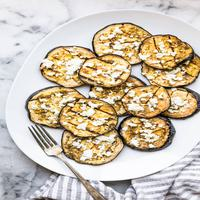


----------------------------------------

Recipe: Coconut Popsicles
Calories: 106.0
Points: 5
Summary: It’s best to store homemade coconut popsicles in the molds to keep them fresh. If you need to use the molds again, you can remove the frozen pops and wrap each of them individually in plastic wrap and store them in a freezer bag or airtight container. They’ll keep for up to 2 months in the freezer.


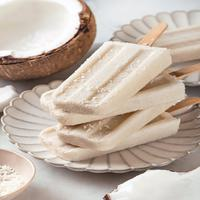


----------------------------------------

Recipe: Blueberry Zucchini Bread
Calories: 111.0
Points: 4
Summary: To make this easy blueberry zucchini bread recipe, mix wet and dry ingredients and bake!The complete instructions are in the recipe card below.


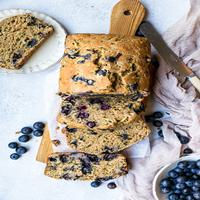


----------------------------------------

Recipe: Pumpkin Spice Latte Recipe
Calories: 115.0
Points: 7
Summary: N/A


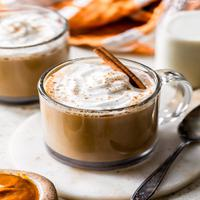


----------------------------------------

Recipe: Lemon Vinaigrette Recipe
Calories: 123.0
Points: 5
Summary: You can use this lemon vinaigrette dressing on more than just salads!


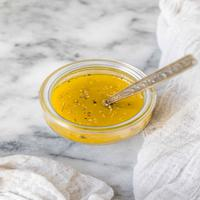


----------------------------------------

Recipe: Apple Bread Recipe
Calories: 124.0
Points: 4
Summary: Here’s the step-by-step recipe for this apple cinnamon bread.See the recipe card below for the exact measurements.


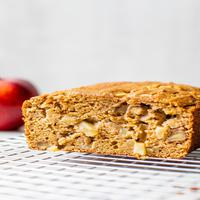


----------------------------------------

Recipe: Mixed Berry Buckle Recipe
Calories: 145.0
Points: 5
Summary: This easy berry buckle recipe doesn’t take long to whip up. Once you pop it in the oven, get ready to enjoy a delicious, warm dessert with juicy berries and a tender crumb.Scroll to the bottom for the complete recipe.


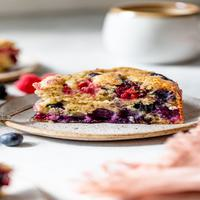


----------------------------------------

Recipe: Cucumber Soup Recipe
Calories: 169.0
Points: 3
Summary: This simple cucumber soup is anexcellent light lunchwith some bread, but it also makes a greatstarterorside dishfordinner. Below are some serving suggestions:


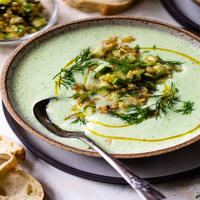


----------------------------------------

Recipe: Autumn Salad with Pears
Calories: 175.0
Points: 5
Summary: Here’s how to make this easy fall salad with pears and gorgonzola.The recipe card below provides complete instructions.


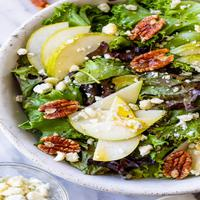


----------------------------------------

Recipe: Roasted Delicata Squash Recipe
Calories: 177.0
Points: 4
Summary: Yes! One of the best things about delicata squash is that you can eat the skin since it’s more delicate and tender. There’s no need to peel it, so it’s much faster to prepare than some other squashes.


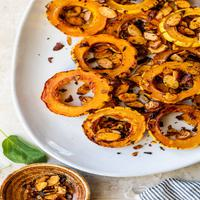


----------------------------------------



In [10]:
#******************************************************************************************[prepare_data]
"Data preparation function"
def prepare_data(df):
    # Ensure the 'Calories' column is treated as string and fill NaN with '0'
    df['Calories'] = df['Calories'].astype(str).fillna('0').str.split().str[0]
    df['Calories'] = pd.to_numeric(df['Calories'], errors='coerce')

    # Convert 'Personal Points' to numeric, handling NaN values
    df['Personal Points'] = pd.to_numeric(df['Personal Points'], errors='coerce')
    
    return df

#******************************************************************************************[interaction_results]
"Interactive function to filter and display recipes with images inline"
def interaction_results(top_recipes, min_calories, max_calories, min_points, max_points):
    # filter recipes based on user input
    filtered_recipes = top_recipes[
        (top_recipes['Calories'] >= min_calories) &
        (top_recipes['Calories'] <= max_calories) &
        (top_recipes['Personal Points'] >= min_points) &
        (top_recipes['Personal Points'] <= max_points)
    ]
    # sort by calories and get the first 10
    sorted_recipes = filtered_recipes.sort_values(by='Calories').head(10)
    # iterate over the DataFrame and display information and images inline
    for idx, row in sorted_recipes.iterrows():
        print(f"Recipe: {row['Name']}")
        print(f"Calories: {row['Calories']}")
        print(f"Points: {row['Personal Points']}")
        print(f"Summary: {row['Summary']}")
        try:
            # request the image from the URL
            response = requests.get(row['Image URL'])
            response.raise_for_status()  # Raises an HTTPError for bad responses
            # load the image from the response content
            img_data = response.content
            # open the image using PIL
            img = PILImage.open(BytesIO(img_data))
            img = img.resize((200, 200), PILImage.LANCZOS)  # Resize the image to 200x200 pixels
            # save the resized image to a BytesIO object
            img_byte_arr = BytesIO()
            img.save(img_byte_arr, format='JPEG')
            img_byte_arr.seek(0)  # Seek to the start of the BytesIO buffer
            # display the resized image inline in Jupyter Notebook using IPython's display
            display(Image(data=img_byte_arr.read()))  # Pass the resized image data here
        except Exception as e:
            print(f"Error loading image: {e}")
        print("\n" + "-" * 40 + "\n")


        
#############################################################

# Prepare the data first
cleaned_recipes_df = prepare_data(cleaned_recipes_df)

# input calorie range
min_calories = int(input("Enter minimum calories: "))
max_calories = int(input("Enter maximum calories: "))

# input point range
min_points = float(input("Enter minimum points: "))
max_points = float(input("Enter maximum points: "))

# debug
# Instead of using input, define ranges for calories and points here
# min_calories = 200  # Example: set to 200 calories
# max_calories = 500  # Example: set to 500 calories
# min_points = 1      # Example: set to 1 point
# max_points = 10  
      
# run function to get results from interaction
interaction_results(cleaned_recipes_df, min_calories, max_calories, min_points, max_points)
